# Quantum Singular Value Transformation (QSVT) 

In this work we will explore the Quantum Singular Value Transformation (QSVT), a framework that unifies many prominent quantum algorithms. 

## Quantum Signal Processing

For pedagogical purposes, we would like to start the discussion of QSVT with Quantum Singular Processing (QSP). Following Martyn et al. [1], we will implement two 
quantum circuits. The first one computes the Chebyshev polynomial of the first kind of a real number $a$, while the second one we can realize the BB1 pulse sequence. 


In [71]:
# import libraries 
import numpy as np
import scipy 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info import Pauli, Operator
from scipy.special import chebyt
from matplotlib import pyplot as plt
import pyqsp
from functools import reduce
from pyqsp import angle_sequence
from IPython.utils import io # this is for suppressing output from pyqsp

In [3]:
# signal rotation operator 
def W(a): 
    '''
    Return the signal rotation operator
    Arguments: 
        a: the parameter of the signal rotation operator, i.e theta = -2acos(a)
    Returns: 
        W: numpy array with the signal rotation operator
    '''
    return np.array([[a, 1j*np.sqrt(1-a**2)], [1j*np.sqrt(1-a**2), a]])

# Quantum signal processing circuit
def create_QSP_circuit(a,phi):
    '''
    Create a QSP circuit with parameters a and phi. 
    Arguments: 
        a  : rotation angle of the signal rotation operator.
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSP 
    '''
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)
    # add the phi0 signal-processing rotation 
    qc.rz(phi[0],q)
    # add the QSP rotations
    for i in range(1,phi.size):
        qc.unitary(W(a),q, label='W')
        qc.rz(-2*phi[i],q)
    return qc


### Chebyshev polynomial with QSP 

Here, we calculate the Chebyshev polynomial of the first kind of order $n$ of a real number $a$. We should note that, in a real Quantum Computer, we don't have 
direct access to the calculated value, since it is encoded as a probability amplitude. So, in a sense, we "cheat" a little bit here. 

Text(0, 0.5, '$T_{5}(x)$')

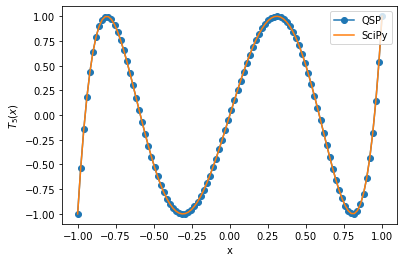

In [4]:
# create the backend, it will be used to run all the circuits
backend = Aer.get_backend('statevector_simulator')

# parameters of the QSP
N = 5 ; # order of the Chebyshev polynomial
phi = np.zeros(N+1) ; # rotation phases

x = np.linspace(-1,1,100)
chebyt_qsp = np.zeros(x.size)
chebyt_builtin = np.zeros(x.size)

for i in range(x.size):
    qc = create_QSP_circuit(x[i],phi)
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    calculated_chebyt = output_state.data[0]
    chebyt_qsp[i] = np.real(calculated_chebyt)
    chebyt_builtin[i] = chebyt(N)(x[i])

# plot the results
plt.plot(x,chebyt_qsp, label='QSP', marker = 'o')
plt.plot(x,chebyt_builtin, label='SciPy')
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$T_{%d}(x)$'%N)

### BB1 Pulse

We reproduce the Figure 1 of [1], which shows the BB1 pulse sequence.

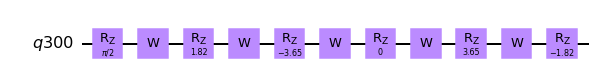

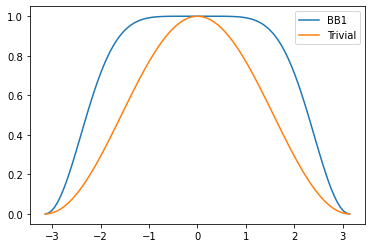

In [5]:
eta = 1/2 * np.arccos(-1/4)
phi = np.array([np.pi/2,-eta, 2*eta,0,-2*eta,eta])
theta = np.linspace(-np.pi,np.pi,100)
p = np.zeros(theta.size)
s = np.zeros(theta.size)

for i in range(theta.size):
    qc = create_QSP_circuit(np.cos(-theta[i]/2),phi)
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    p[i]= np.abs(output_state.data[0])**2
    qc = create_QSP_circuit(np.cos(-theta[i]/2),np.array([0,0]))
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    s[i]= np.abs(output_state.data[0])**2

# plot the probability with respect to theta
#p_theoretical = 1/8 * np.cos(theta/2)**2 *[3*np.cos(theta/2)**8 - 15*np.cos(theta/2)**6 + 35*np.cos(theta/2)**4 - 45*np.cos(theta/2)**2 + 30]
plt.plot(theta,p, label = 'BB1')
plt.plot(theta,s, label = 'Trivial')
plt.legend()

# plot the quantum signal processing circuit, for theta = -pi 
qc = create_QSP_circuit(np.cos(-theta[0]/2),phi)
qc.draw(output = 'mpl')


## Search by QSVT

We will now use the QSVT to implement a search algorithm. Some remarks: 
1. The unitary matrix we wish to block encode is the $H^{\otimes n}$, where $H$ is the Hadamard gate. In the paper they block encode the identity matrix, assuming that the initial state is the uniform superposition. Here, we assume that the initial state is the zero state and we block encode the $H^{\otimes n}$ matrix. 
2. In order to apply the projector controlled phase shift, we used the fact that $e^{i(2P-1)x} = cos(x) + (2P-I)sin(x)$, where $P$ is the projector. This is relation can be easily proved by using the euler formula for the exponential function, expanding the sine and cosine functions as a power series and using the fact that $P^2 = P$.
3. The phases for the sign approximation are calculated using the python library pyqsp. 
4. In general, in a search algorithm, we assume that we have an oracle that marks the solution. Using that oracle, we can implement the projector controlled phase shift to the marked state, even if we don't know the marked state. In our case, we just chose a random marked state and defined the projector that projects onto that state. This is not what we would do in a real search algorithm, but we assumed it here for simplicity. 


Possible improvements:
1) Use an oracle that marks a particular state instead of choosing a random state. It is not crucial, but it would be more realistic.

In [74]:
from qiskit.quantum_info import partial_trace
from qiskit.circuit.library import GlobalPhaseGate

def p_controlled_phase_shift(P, phi):
    '''
    Return the projector-controlled phase shift operator. 
    Arguments:
        P  : the projector
        phi: the rotation angle
    Returns:
        U  : numpy array with the projector-controlled phase shift operator
    Note: This is for educational purposes only. For a more efficient implementation, see the function projector_controlled_phase_shift below.
    '''
    N = len(P)
    return np.eye(N)*np.cos(phi)+1j*(2*P-np.eye(N))*np.sin(phi)

def projector_controlled_phase_shift(P, phi, num_qubits, kind): 
    '''
    Return a quantum circuit realizing the projector-controlled phase shift operator, as described in the paper.
    Arguments:
        P  : the projector
        phi: the rotation angle
        num_qubits: the number of qubits
        kind: 'left' or 'right', depending on whether the projector is the left or the right projector. It is used only for nice printing of the circuit.
    Returns:
        qc : a quantum circuit realizing the projector-controlled phase shift operator
    '''

    # This is only for nice printing of the circuit, with notation compatible with the paper
    if kind == 'left': 
        label = r'$C_{\widetilde{\Pi}}NOT$'
    elif kind == 'right':
        label = r'$C_{\Pi}NOT$'
    else:
        label = r'$A$' # some arbitrary label
        

    # Create the quantum circuit
    q = QuantumRegister(num_qubits+1)
    qc = QuantumCircuit(q)
    qc.barrier()

    # Define the operator 
    projector = Operator(P)
    X = Operator.to_operator(Pauli('X'))
    I_n = Operator.to_operator(Pauli('I'*num_qubits))
    I = Operator.to_operator(Pauli('I'))
    P_dim = np.shape(projector)[0]
    projector_controlled_not = (projector^X) + ((I_n - projector)^I)
    
    # create the circuit
    qc.unitary(projector_controlled_not, q, label = label)
    qc.rz(2*phi, q[0])
    qc.unitary(projector_controlled_not, q, label = label)
    qc.barrier()
    
    return qc

def create_qsvt_circuit(U,PL,PR, phi, num_qubits):

    '''
    Create a QSVT circuit with parameters U, PL, PR and phi. 
    Arguments: 
        U  : the unitary operator, which block encodes the matrix of interest
        PL : the left projector
        PR : the right projector
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSVT 
    '''
    # create the quantum circuit
    q = QuantumRegister(num_qubits+1) # the first qubit is the ancilla
    qc = QuantumCircuit(q)

    N = len(phi)
    d = N - 1
    if len(phi)%2 != 0:
        # if the number of phases is odd, then the polynomial is of even degree, Pr = Pi and Pl = Pi_tilde
        #qc.unitary(p_controlled_phase_shift(PR,phi[-1]),q, label = (r'${\Pi}_{' + str(d)) + '}$')
        qc.compose(projector_controlled_phase_shift(PR,phi[-1], num_qubits,kind = 'right'), inplace = True)
        for i in reversed(range((d//2))):
            # apply the unitary operator to all but the ancilla qubit
            qc.unitary(U,q[1:], label = (r'U'))
            #qc.unitary(p_controlled_phase_shift(PL,phi[2*i+1]),q, label = (r'$\widetilde{\Pi}_{' + str(2*i+1)) + '}$')
            qc.compose(projector_controlled_phase_shift(PL,phi[2*i+1], num_qubits, kind = 'left'), inplace = True)
            qc.unitary(U.T.conj(),q[1:], label = (r'U$^\dagger$'))
            #qc.unitary(p_controlled_phase_shift(PR,phi[2*i]),q, label = (r'${\Pi}_{' + str(2*i)) + '}$')
            qc.compose(projector_controlled_phase_shift(PR,phi[2*i], num_qubits, kind = 'right'), inplace = True)
    else:
        # if the number of phases is even, then the polynomial is of odd degree
        #qc.unitary(p_controlled_phase_shift(PR,phi[d]),q[1:], label = (r'${\Pi}_{' + str(d)) + '}$') 
        qc.compose(projector_controlled_phase_shift(PR,phi[d], num_qubits, kind = 'right'), inplace = True)
        for i in reversed(range(1, (d-1)//2+1)):
            qc.unitary(U,q[1:], label = (r'U'))     

            #qc.unitary(p_controlled_phase_shift(PL,phi[2*i]),q[1:], label = (r'$\widetilde{\Pi}_{' + str(2*i)) + '}$')
            qc.compose(projector_controlled_phase_shift(PL,phi[2*i], num_qubits, kind = 'left'), inplace = True)

            qc.unitary(U.T.conj(),q[1:], label = (r'U$^\dagger$'))
            
            #qc.unitary(p_controlled_phase_shift(PR,phi[2*i-1]),q[1:], label = (r'${\Pi}_{' + str(2*i-1)) + '}$')
            qc.compose(projector_controlled_phase_shift(PR,phi[2*i-1], num_qubits, kind ='right'), inplace = True)
        qc.unitary(U,q[1:], label = (r'U'))
        #qc.unitary(p_controlled_phase_shift(PL,phi[0]),q[1:], label = (r'$\widetilde{\Pi}_{' + str(0)) + '}$')
        qc.compose(projector_controlled_phase_shift(PL,phi[0], num_qubits, kind = 'left'), inplace = True)
    return qc

def angles_from_W_to_R(phis):
    """Converts QSP angles from W-convention to R-convention.
    Arguments:
        phis: numpy array with the QSP angles in W-convention
    Returns:
        phis: numpy array with the QSP angles in R-convention
    """
    # see page 27 of grand unification paper
    phis = [phis[0]+(2*(len(phis)-1)-1)*np.pi/4] + [phi-np.pi/2 for phi in phis[1:-1]] + [phis[-1]-np.pi/4]
    return phis 

def sign_approximating_polynomial(num_qubits):
    """Polynomial that approximates the step function theta(x) for x>= 1/N**0.5
    Arguments:
        num_qubits: number of qubits
    Returns:
        p: the desired polynomial
    """
    
    N = 2**num_qubits
    target_function = pyqsp.poly.PolySign()
    # we take the closest odd number to N**0.5. 
    degree = np.ceil(N**0.5) 
    if degree % 2 == 0:
        degree += 1
            
    # this is connected to the width of our approximation
    Delta = N**0.5
    
    # Find the polynomial approximation.
    p = target_function.generate(degree, delta=Delta)
    
    return p

Initial probability amplitude:  0.17677669529663687
[pyqsp.poly.PolySign] degree=7, delta=5.656854249492381
[PolyTaylorSeries] max [0.89508306] is at [0.96694539]: normalizing
[PolyTaylorSeries] average error = 0.138576375175681 in the domain [-1, 1] using degree 7
Approximating polynomial value:  0.5256859152453003
Probability amplitude after QSVT:  (0.5256333469234883-0.28212004866592943j)


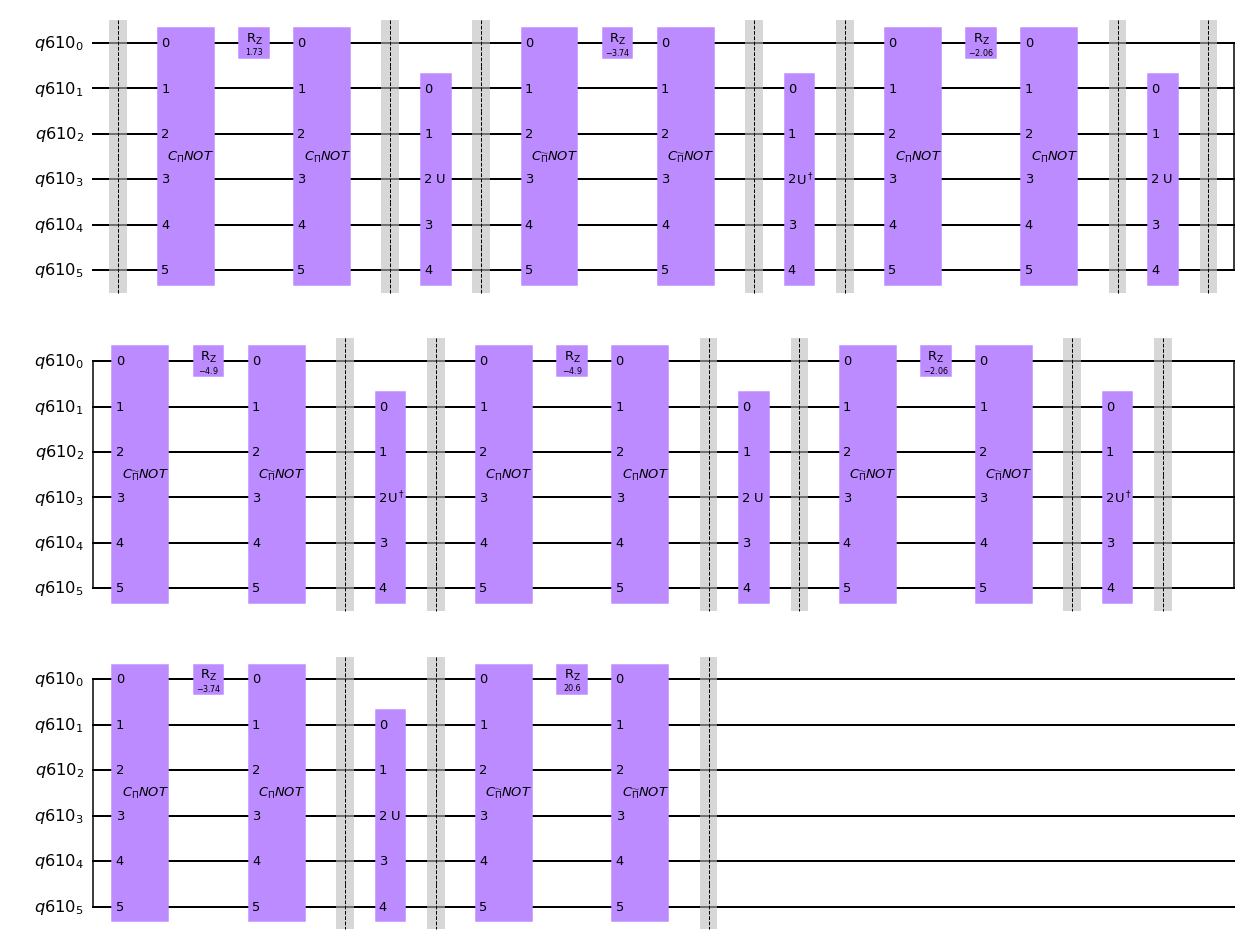

In [77]:
np.random.seed(42)

num_qubits = np.arange(2,8) # number of qubits
amplitudes = np.zeros(num_qubits.size) # probability amplitudes, after QSVT

for i,qubits in enumerate(num_qubits):
    
    # U is the unitary operator which we block encode. It is just the Hadamard gate applied to all qubits
    H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
    U = reduce(np.kron, [H]*qubits)

    # define the right projector
    all_zero_state = np.zeros(2**qubits) ; all_zero_state[0] = 1
    PR = np.outer(all_zero_state,all_zero_state.conj())

    # define the left projector - we choose it randomly. In a real application, we would have indirect access to it, through the oracle
    r = np.random.randint(0,2**qubits)
    m = np.zeros(2**qubits) ; m[r] = 1
    PL = np.outer(m,m.conj())

    # Estimate the phases, suppressing the output of pyqsp
    with io.capture_output() as captured:
        p = sign_approximating_polynomial(qubits)
        phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')

    # convert the phases from W-convention to R-convention
    phi = angles_from_W_to_R(phi)

    # create the QSVT circuit
    backend = Aer.get_backend('statevector_simulator')
    qsvt_circuit = create_qsvt_circuit(U,PL,PR, phi, qubits)

    # run the circuit and get the output statevector
    job = backend.run(qsvt_circuit)
    result = job.result()
    output_state = np.array(result.get_statevector(qsvt_circuit))

    # find the probability of measuring the |m> state
    prob_ampl = output_state[2*r]
    

    # find the overlap between the output state and the |m> state. Since we also have the ancilla qubit, we need to multiply by 2


    # print the results
    
    print('Approximating polynomial value: ', sign_approximating_polynomial(qubits)(2**(-0.5*qubits)))
    print('Probability amplitude after QSVT: ', prob_ampl)





In [ ]:
# plot the circuit
qsvt_circuit.draw(output = 'mpl')

In [27]:
def projector_rotation(P, phi):
    """Computes exponential of a projector using relation e^{i (2P-1) x}= cos(x)+i(2P-1)sin(x)"""
    N = len(P)
    return np.eye(N)*np.cos(phi)+1j*(2*P-np.eye(N))*np.sin(phi)


def apply_QSVT(U, PL, PR, phis):
    
    phi_last = phis[-1]
    
    if len(phis) % 2 == 1: # Even polynomial
        phis_paired = phis[:-1]
        phi_0 = None
    else: # Odd polynomial
        phis_paired = phis[1:-1]
        phi_0 = phis[0]
    
    res = projector_rotation(PR, phi_last)
    
    for phi_R, phi_L in np.array(phis_paired).reshape(-1, 2)[::-1]:
        res =  projector_rotation(PR, phi_R) @ U.conj().T @  projector_rotation(PL, phi_L) @ U @ res
    
    if phi_0 is not None:
        res = projector_rotation(PL, phi_0) @ U @ res
        
    return res


np.random.seed(42)

def projector_from_state(state):
    """Builds |n><n| from |n>."""
    
    return np.outer(state, state.conj())


num_qubits = 5
N = 2**num_qubits

# Define initial state |0> and the associated projector.
all_zero_state = np.zeros(N)
all_zero_state[0] = 1
PR = projector_from_state(all_zero_state)

# Define a random marked state |m>. It will only be accessed via the corresponding projector.
marked_state = np.zeros(N)
marked_state[np.random.randint(0, N)] = 1
PL = projector_from_state(marked_state)

# Signal operator is the n-th tensor power of the Hadamard gate.
H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
U = reduce(np.kron, [H]*num_qubits)

# We will approximate the step function.
p = sign_approximating_polynomial(num_qubits)

# Determine QSP angles
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
phis = angles_from_W_to_R(phis)

# Construct the QSVT sequence
U_phi = apply_QSVT(U, PL, PR, phis)

# Determine the overlap with the marked state.
# Recall that takind the real part corresponds to combining two QSVT sequence and is not exactly trivial
# at the level of circuits.
amplitude = (marked_state @ U_phi @ all_zero_state)
print('Approximation of the step function value: ', sign_approximating_polynomial(num_qubits)(2**(-0.5*num_qubits)))
print('Probability of measuring the marked state: ', np.abs(amplitude)**2)
print('probability amplitude: ', amplitude)
print('real part: ', np.real(amplitude))


# print probability of every state
state_vector = U_phi @ all_zero_state
for i in range(2**num_qubits):
    print('Probability of measuring state %d: '%i, np.abs(state_vector[i])**2)


[pyqsp.poly.PolySign] degree=7, delta=5.656854249492381
[PolyTaylorSeries] max [0.89508306] is at [0.96694539]: normalizing
[PolyTaylorSeries] average error = 0.138576375175681 in the domain [-1, 1] using degree 7
[pyqsp.poly.PolySign] degree=7, delta=5.656854249492381
[PolyTaylorSeries] max [0.89508306] is at [0.96694539]: normalizing
[PolyTaylorSeries] average error = 0.138576375175681 in the domain [-1, 1] using degree 7
Approximation of the step function value:  0.5256859152453003
Probability of measuring the marked state:  0.3558821372572544
probability amplitude:  (0.5256333469234882-0.2821200486659295j)
real part:  0.5256333469234882
Probability of measuring state 0:  0.020777995572346608
Probability of measuring state 1:  0.020777995572346577
Probability of measuring state 2:  0.020777995572346577
Probability of measuring state 3:  0.020777995572346577
Probability of measuring state 4:  0.02077799557234659
Probability of measuring state 5:  0.02077799557234659
Probability of me

### Polynomial approximation

We show some approximations of the sign function using polynomials of different degrees. We can see that the approximation gets better as the degree of the polynomial increases.

[pyqsp.poly.PolySign] degree=3, delta=2.0
[PolyTaylorSeries] max [0.88487764] is at [0.89510929]: normalizing
[PolyTaylorSeries] average error = 0.12112171443398506 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=2.8284271247461903
[PolyTaylorSeries] max [0.86327883] is at [0.86147542]: normalizing
[PolyTaylorSeries] average error = 0.19244082131510504 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=5, delta=4.0
[PolyTaylorSeries] max [0.90000001] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13772714862145935 in the domain [-1, 1] using degree 5
[pyqsp.poly.PolySign] degree=7, delta=5.656854249492381
[PolyTaylorSeries] max [0.89508306] is at [0.96694539]: normalizing
[PolyTaylorSeries] average error = 0.138576375175681 in the domain [-1, 1] using degree 7
[pyqsp.poly.PolySign] degree=9, delta=8.0
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13632827412557 in the domain [-1, 1] usin

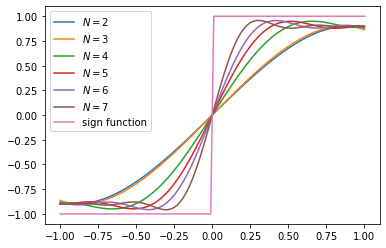

In [28]:
# check the polynomial approximation for different values of qubits 
N = np.arange(2,8)
for n in N:
    p = sign_approximating_polynomial(n)
    x = np.linspace(-1,1,100)
    plt.plot(x,p(x), label = r'$N = %d$'%n)

# plot the sign function
plt.plot(x,np.sign(x), label = 'sign function')
plt.legend()



Here we implement the actual search algorithm. We notice that using that circuit amplifies the probability of measuring the marked state, according to the approximation of sign function, i.e the probability amplitute after applying the circuit is equal to the value of the approximating polynomial. 

In [22]:
from functools import reduce
from pyqsp import angle_sequence

np.random.seed(42)
qubits = 4; 

# apply the hadamard gate to all qubits
H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U = reduce(np.kron, [H]*qubits)

# Create the qsvt circuit

# define the left projector
all_zero_state = np.zeros(2**qubits) ; all_zero_state[0] = 1
PR = np.outer(all_zero_state,all_zero_state.conj())
# define the right projector
r = np.random.randint(0,2**qubits)
m = np.zeros(2**qubits) ; m[r] = 1
PL = np.outer(m,m.conj())

# Estimate the phases 
p = sign_approximating_polynomial(qubits)
phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
phi = angles_from_W_to_R(phi)

# create the circuit
backend = Aer.get_backend('statevector_simulator')
qsvt_circuit = create_qsvt_circuit(U,PL,PR, phi, qubits)

# run the circuit and get the output statevector
job = backend.run(qsvt_circuit)
result = job.result()
output_state = np.array(result.get_statevector(qsvt_circuit))

# find the probability of measuring the |m> state
initial_prob_ampl = 1/np.sqrt(2**qubits)

# find the overlap between the output state and the |m> state
prob_ampl = output_state[r]

# print the results
print('Initial probability amplitude: ', initial_prob_ampl)
print('Approximating polynomial value: ', sign_approximating_polynomial(qubits)(2**(-0.5*qubits)))
print('Probability amplitude after QSVT: ', prob_ampl)


[pyqsp.poly.PolySign] degree=5, delta=4.0
[PolyTaylorSeries] max [0.90000001] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13772714862145935 in the domain [-1, 1] using degree 5
Initial probability amplitude:  0.25
[pyqsp.poly.PolySign] degree=5, delta=4.0
[PolyTaylorSeries] max [0.90000001] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13772714862145935 in the domain [-1, 1] using degree 5
Approximating polynomial value:  0.5591529553315698
Probability amplitude after QSVT:  (0.5590970888592798+0.20579316989997803j)


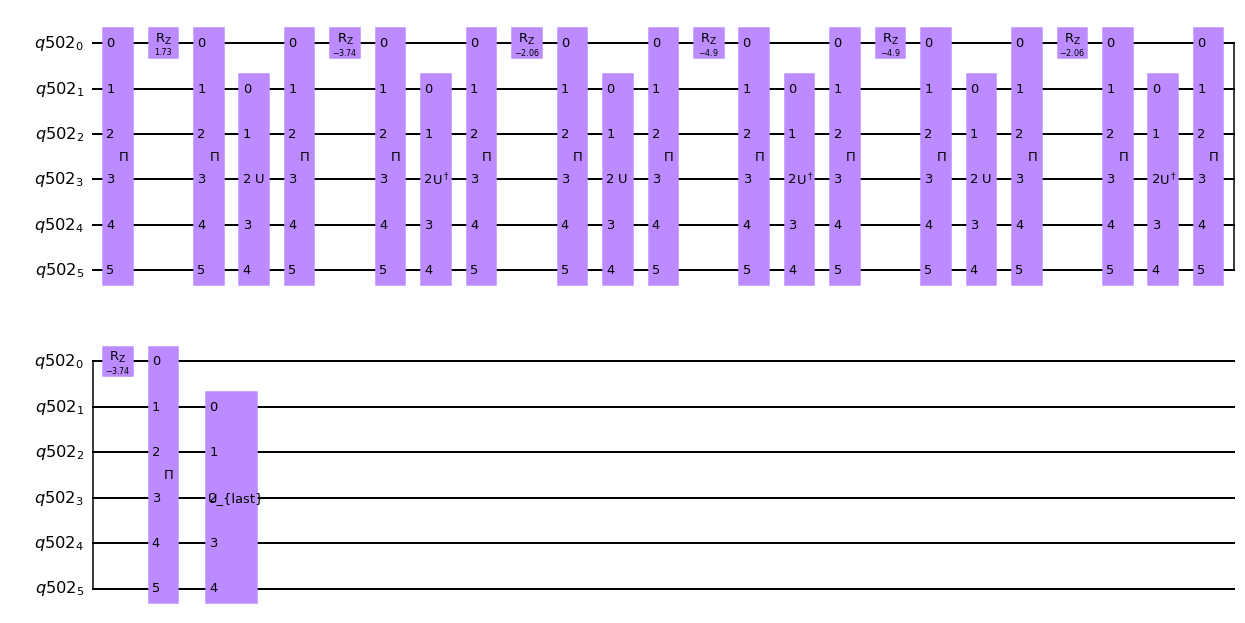

In [61]:
# draw the circuit
qsvt_circuit.draw(output = 'mpl')


In [62]:
phi

[10.29184773896564,
 -1.8693757019779524,
 -1.0275639408964834,
 -2.451385367308838,
 -2.451385367308828,
 -1.027563940896456,
 -1.8693757019779582,
 0.8670697781962464]

## Solving Linear Systems of Equations

In [10]:
def block_encode(A, num_qubits):
    """Block-encodes a matrix A into a unitary U.
    Args:
        A: The matrix to block-encode. We assume that the operator norm of A is <= 1.
        num_qubits: The number of qubits to use.
    Returns:
        A unitary U such that U|0> = |A>.
    """
    
    
    
    
    return Operator(A)


def xinverse_approximating_polynomial(kappa, epsilon):
    """Polynomal approxiamtion to 1/(2*kappa*x)"""
    
    target_function = pyqsp.poly.PolyOneOverX()
    coeffs, scale = target_function.generate(kappa=kappa, epsilon=epsilon, return_scale=True)
    
    # For some reason, pyqsp returns 1/x*scale with some `scale`
    # that might be different from 1/kappa. 
    # We remove this scale from our polynomial.
    
    return np.polynomial.Polynomial(coeffs/(scale*2*kappa))

def random_A(kappa, num_qubits, seed):
    """Construnct a random real operator A with ||A||<1 and condition number <= kappa.
        Size of A is n by m, which a both smaller than 2**num_qubits."""

    N = 2**num_qubits

    n, m = np.random.randint(N//2, N, size=2)  # Lets make N>= n,m >= N/2
    V = scipy.stats.ortho_group.rvs(n, random_state=seed**2)
    W = scipy.stats.ortho_group.rvs(m, random_state=seed**3)

    singular_values = np.random.uniform(low=1/kappa, high=1, size=min(n, m))
    Sigma = np.zeros((n, m))
    Sigma[:min(n, m), :min(n, m)] = np.diag(singular_values)

    A = V @ Sigma @ W.conj().T
    
    
    return A


## Literature
[1] J. M. Martyn, Z. M. Rossi, A. K. Tan, and I. L. Chuang, A Grand Unification of Quantum Algorithms, PRX Quantum 2, (2021).

[2] A. Gilyén, Y. Su, G. H. Low, and N. Wiebe, Quantum singular value transformation and beyond: Exponential improvements for quantum matrix arithmetics, Proceedings of the Annual ACM Symposium on Theory of Computing 193 (2019).

[3] A. Gilyén, Quantum Singular Value Transformation& Its Algorithmic Applications, (2019).

[4] I. Chuang and et al, Pyqsp: Quantum Signal Processing, (2022).

[5] Introduction to Quantum Singular Value Transformation, https://idnm.github.io/blog/posts/quantum_singular_value_transformation_intro/
